<h1 align="center">Deep Learning</h1>
<h4 align="center">Dr. Fatemi Zadeh</h4>
<h4 align="center">Sharif University of Technology, Fall 2024</h4>
<h4 align="center">Practical Assignment 3 </h4>



**Student Name**: Radin Khayyam

**Student ID**: 99101579

---

# **Question 1:**

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

 # **Part a)**
 The dataset used in this exercise is CIFAR-10, which consists of a total of 60,000 images, including 50,000 training images and 10,000 test images across 10 different classes. First, use torchvision.datasets to download the CIFAR-10 dataset and separate the train and test data. Then, split 10,000 images from the training data for validation. Perform any necessary preprocessing on the data during the download if required. Finally, display a random image from each class in the dataset along with its label.

Files already downloaded and verified
Files already downloaded and verified


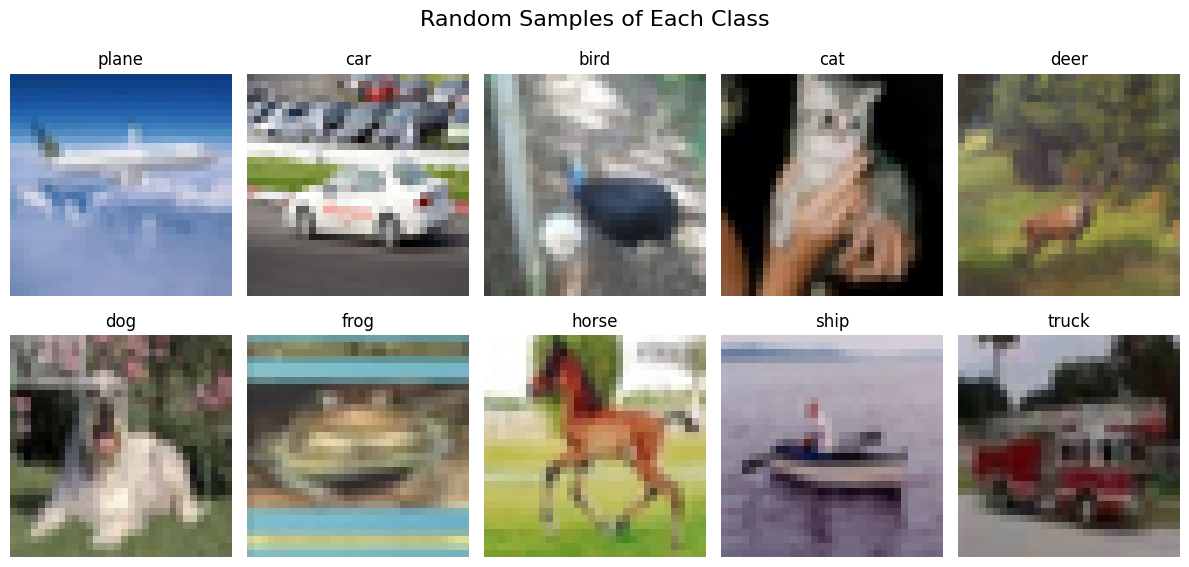

In [9]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset and load train and test data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset, val_dataset = random_split(train_dataset, [40000, 10000])

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to unnormalize and convert tensor to numpy array for visualization
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg,(1, 2, 0)))

# Plot a random sample of each class
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Random Samples of Each Class', fontsize=16)

random_samples = {class_name: None for class_name in classes}

for data, label in train_dataset:
    label_name = classes[label]
    if random_samples[label_name] is None:
        random_samples[label_name] = data
    if all(value is not None for value in random_samples.values()):
        break

for idx, class_name in enumerate(classes):
    ax = axes[idx // 5, idx % 5]
    ax.axis('off')
    ax.set_title(class_name)
    imshow(random_samples[class_name], ax)

plt.tight_layout()
plt.show()


# **Part b)**
Using torch.utils.data.DataLoader, split your data into different batches. Then, train the pre-written model below and report the accuracy and loss on the train and validation datasets.

In [16]:
# Setup a Data Loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch [1/20] Train Loss: 1.4750, Train Acc: 0.4895 | Val Loss: 1.3397, Val Acc: 0.5481
Epoch [2/20] Train Loss: 1.2266, Train Acc: 0.5856 | Val Loss: 1.3009, Val Acc: 0.5570
Epoch [3/20] Train Loss: 1.1401, Train Acc: 0.6179 | Val Loss: 1.2528, Val Acc: 0.5906
Epoch [4/20] Train Loss: 1.0750, Train Acc: 0.6384 | Val Loss: 1.2679, Val Acc: 0.5925
Epoch [5/20] Train Loss: 1.0178, Train Acc: 0.6555 | Val Loss: 1.2879, Val Acc: 0.5915
Epoch [6/20] Train Loss: 0.9730, Train Acc: 0.6725 | Val Loss: 1.3570, Val Acc: 0.5870
Epoch [7/20] Train Loss: 0.9350, Train Acc: 0.6845 | Val Loss: 1.3822, Val Acc: 0.5787
Epoch [8/20] Train Loss: 0.8965, Train Acc: 0.6961 | Val Loss: 1.4473, Val Acc: 0.5829
Epoch [9/20] Train Loss: 0.8711, Train Acc: 0.7057 | Val Loss: 1.5023, Val Acc: 0.5647
Epoch [10/20] Train Loss: 0.8415, Train Acc: 0.7167 | Val Loss: 1.4872, Val Acc: 0.5759
Epoch [11/20] Train Loss: 0.8094, Train Acc: 0.7248 | Val Loss: 1.6153, Val Acc: 0.5604
Epoch [12/20] Train Loss: 0.7848, Train A

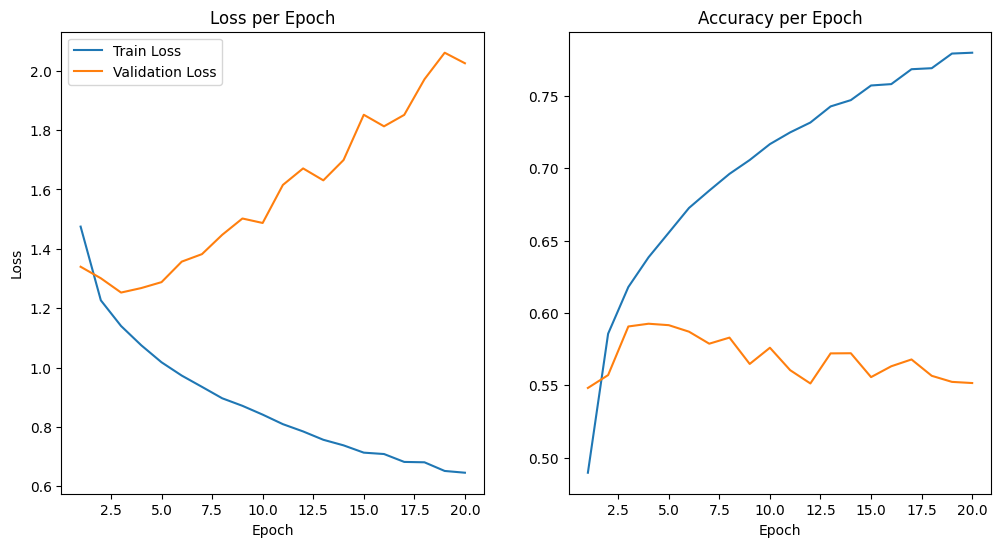

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define BaselineModel
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Training and validation function
def train_model(model, train_loader, criterion, optimizer, num_epochs=30, model_name='default'):
    model.train()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = np.inf  # To track the best model
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Track loss and accuracy
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(total_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
    
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                # Track loss and accuracy
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
    
        val_losses.append(total_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
    
        # Save the best model
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), 'best_'+model_name+'.pth')
    
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
        
    return train_losses, train_accuracies, val_losses, val_accuracies

# Plot loss and accuracy
def plot_results (train_losses, train_accuracies, val_losses, val_accuracies):
    num_epochs = len(train_losses)
    epochs_range = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')


# Initialize model, loss function, and optimizer
model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20, model_name='BaselineModel')
plot_results (train_losses, train_accuracies, val_losses, val_accuracies)

In the Baseline model, the simplicity of the architecture significantly limits its ability to learn and represent the complexity of the CIFAR-10 dataset. This is evident as the training accuracy did not exceed 80%, highlighting that the model struggles to even memorize the training data. This limitation suggests the need for a more complex model with additional layers or advanced techniques to capture the nuances of the data and achieve better performance.

# **Part c)**
Enhance the baseline model. To build the desired neural network, use up to 4 convolutional layers along with several pooling layers. The choice of filter size and the number of filters in each layer is up to you. The maximum number of fully connected (FC) layers is 3. Report the results.

Epoch [1/20] Train Loss: 1.8949, Train Acc: 0.2762 | Val Loss: 1.5363, Val Acc: 0.4102
Epoch [2/20] Train Loss: 1.3108, Train Acc: 0.5151 | Val Loss: 1.1948, Val Acc: 0.5630
Epoch [3/20] Train Loss: 1.0164, Train Acc: 0.6359 | Val Loss: 0.9309, Val Acc: 0.6710
Epoch [4/20] Train Loss: 0.8074, Train Acc: 0.7167 | Val Loss: 0.8253, Val Acc: 0.7175
Epoch [5/20] Train Loss: 0.6725, Train Acc: 0.7641 | Val Loss: 0.8331, Val Acc: 0.7089
Epoch [6/20] Train Loss: 0.5596, Train Acc: 0.8024 | Val Loss: 0.7856, Val Acc: 0.7446
Epoch [7/20] Train Loss: 0.4643, Train Acc: 0.8382 | Val Loss: 0.8809, Val Acc: 0.7228
Epoch [8/20] Train Loss: 0.3780, Train Acc: 0.8680 | Val Loss: 0.8426, Val Acc: 0.7417
Epoch [9/20] Train Loss: 0.3161, Train Acc: 0.8889 | Val Loss: 1.0553, Val Acc: 0.7266
Epoch [10/20] Train Loss: 0.2801, Train Acc: 0.9027 | Val Loss: 0.9250, Val Acc: 0.7395
Epoch [11/20] Train Loss: 0.2336, Train Acc: 0.9181 | Val Loss: 1.0543, Val Acc: 0.7294
Epoch [12/20] Train Loss: 0.1909, Train A

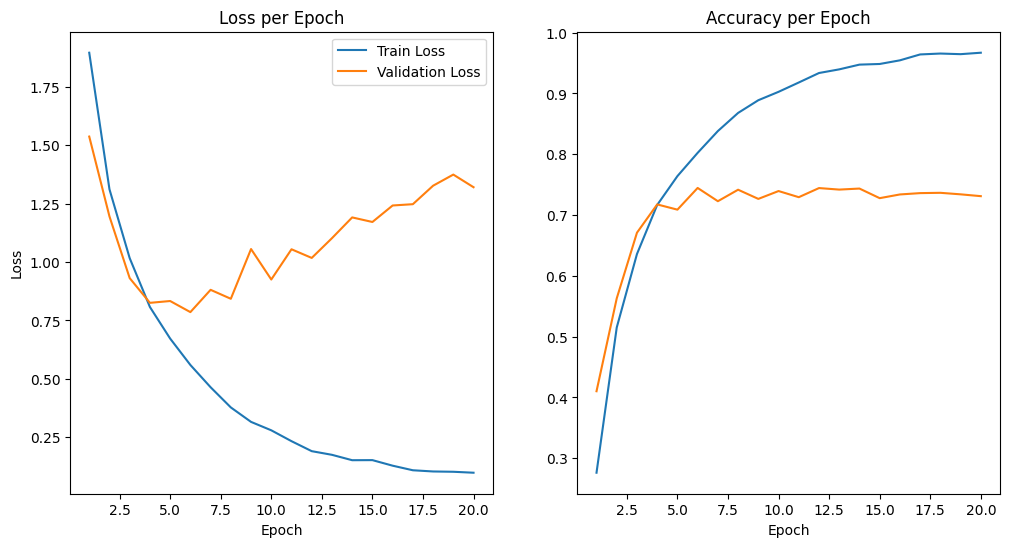

In [24]:
# Define the enhanced CNN model
class EnhancedModel(nn.Module):
    def __init__(self):
        super(EnhancedModel, self).__init__()
        # Convolutional and pooling layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First conv layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Third conv layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Fourth conv layer

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)  # First FC layer
        self.fc2 = nn.Linear(512, 128)  # Second FC layer
        self.fc3 = nn.Linear(128, 10)  # Output layer for 10 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)  # Flatten before FC layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = EnhancedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20, model_name='EnhancedModel')
plot_results (train_losses, train_accuracies, val_losses, val_accuracies)

After adding layers and making the model more complex, the training accuracy reached around 96%, which is promising. However, the validation accuracy did not exceed 73%, indicating that the model is overfitting. This suggests the need to apply regularization methods to prevent the model from overfitting and improve its generalization performance.

# **Part d)**
In the course, you became familiar with the Batch Normalization layer. Appropriately insert the BN layer(s) between the convolutional layers of the best network from the previous section, and report and analyze the results.

Epoch [1/20] Train Loss: 1.3212, Train Acc: 0.5163 | Val Loss: 1.0683, Val Acc: 0.6290
Epoch [2/20] Train Loss: 0.9163, Train Acc: 0.6778 | Val Loss: 1.0190, Val Acc: 0.6528
Epoch [3/20] Train Loss: 0.7521, Train Acc: 0.7357 | Val Loss: 0.9392, Val Acc: 0.6730
Epoch [4/20] Train Loss: 0.6289, Train Acc: 0.7828 | Val Loss: 0.6869, Val Acc: 0.7661
Epoch [5/20] Train Loss: 0.5352, Train Acc: 0.8146 | Val Loss: 0.7984, Val Acc: 0.7427
Epoch [6/20] Train Loss: 0.4538, Train Acc: 0.8403 | Val Loss: 0.6981, Val Acc: 0.7679
Epoch [7/20] Train Loss: 0.3834, Train Acc: 0.8662 | Val Loss: 0.6741, Val Acc: 0.7844
Epoch [8/20] Train Loss: 0.3165, Train Acc: 0.8894 | Val Loss: 0.7812, Val Acc: 0.7702
Epoch [9/20] Train Loss: 0.2565, Train Acc: 0.9101 | Val Loss: 0.7928, Val Acc: 0.7710
Epoch [10/20] Train Loss: 0.2090, Train Acc: 0.9267 | Val Loss: 0.8034, Val Acc: 0.7856
Epoch [11/20] Train Loss: 0.1790, Train Acc: 0.9371 | Val Loss: 0.8680, Val Acc: 0.7805
Epoch [12/20] Train Loss: 0.1463, Train A

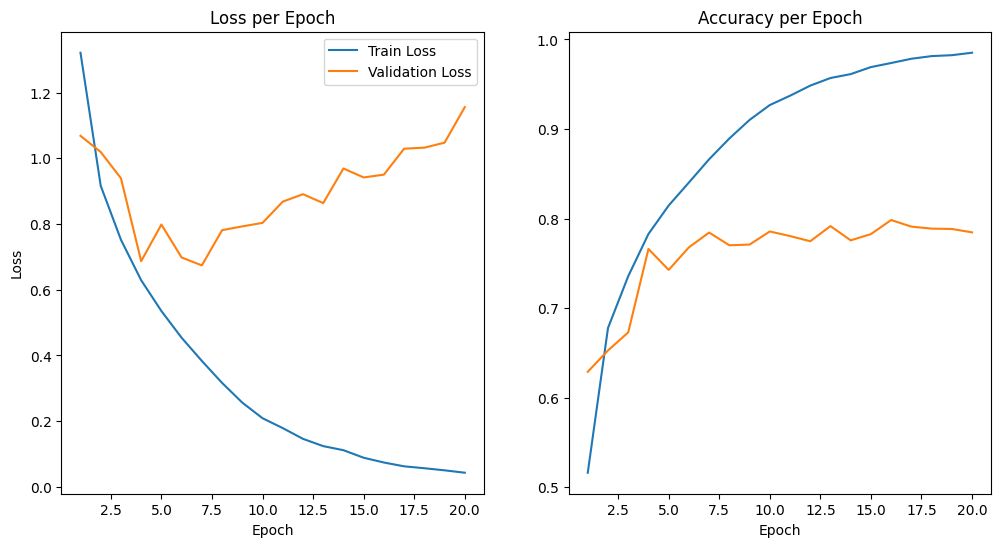

In [25]:
class BNModel(nn.Module):
    def __init__(self):
        super(BNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize and train BN-enhanced model
model = BNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20, model_name='BNModel')
plot_results (train_losses, train_accuracies, val_losses, val_accuracies)

After adding batch normalization layers between the convolutional layers, the validation accuracy increased to around 80%, demonstrating that the regularization technique is effectively preventing the model from overfitting.

# **Part e)**
To the best model from the previous section, this time add the Dropout layer(s) between the fully connected (FC) layers and report the results again. Have the results improved? Analyze them.

Epoch [1/20] Train Loss: 1.9480, Train Acc: 0.2574 | Val Loss: 1.5983, Val Acc: 0.3997
Epoch [2/20] Train Loss: 1.4306, Train Acc: 0.4715 | Val Loss: 1.2272, Val Acc: 0.5527
Epoch [3/20] Train Loss: 1.1716, Train Acc: 0.5847 | Val Loss: 1.0468, Val Acc: 0.6342
Epoch [4/20] Train Loss: 0.9841, Train Acc: 0.6580 | Val Loss: 0.9220, Val Acc: 0.6859
Epoch [5/20] Train Loss: 0.8572, Train Acc: 0.7046 | Val Loss: 0.8424, Val Acc: 0.7115
Epoch [6/20] Train Loss: 0.7513, Train Acc: 0.7425 | Val Loss: 0.8521, Val Acc: 0.7098
Epoch [7/20] Train Loss: 0.6695, Train Acc: 0.7717 | Val Loss: 0.7757, Val Acc: 0.7388
Epoch [8/20] Train Loss: 0.6024, Train Acc: 0.7987 | Val Loss: 0.8046, Val Acc: 0.7314
Epoch [9/20] Train Loss: 0.5396, Train Acc: 0.8181 | Val Loss: 0.7569, Val Acc: 0.7528
Epoch [10/20] Train Loss: 0.4879, Train Acc: 0.8362 | Val Loss: 0.7824, Val Acc: 0.7422
Epoch [11/20] Train Loss: 0.4499, Train Acc: 0.8465 | Val Loss: 0.8233, Val Acc: 0.7512
Epoch [12/20] Train Loss: 0.4224, Train A

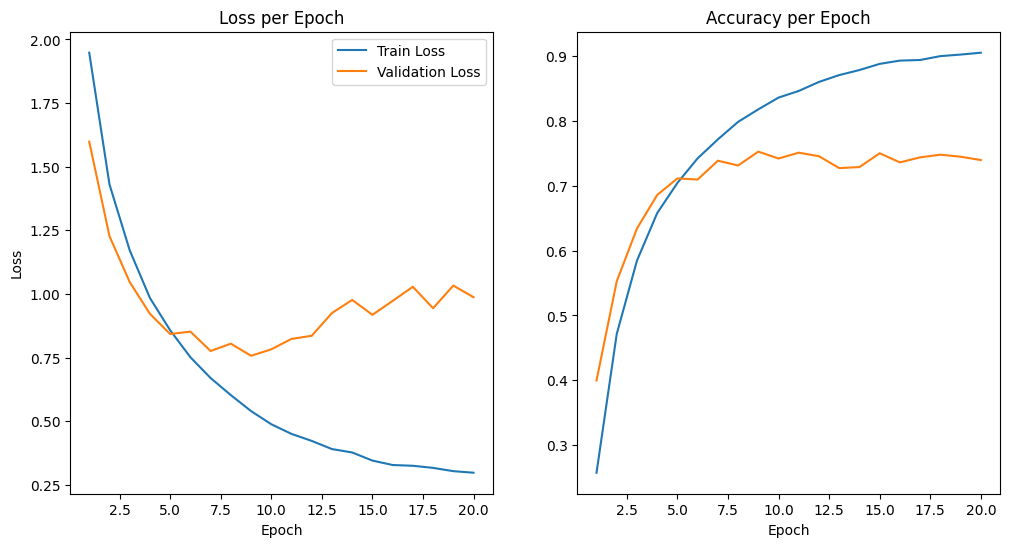

In [28]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize and train the Dropout model
model = DropoutModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20, model_name='DropoutModel')
plot_results (train_losses, train_accuracies, val_losses, val_accuracies)

We expected to see an additional increase in the validation accuracy by adding dropout layers between the fully connected layers, but instead, the validation accuracy decreased to around 75%. This suggests that further improvements in accuracy using regularization techniques may no longer be effective. To achieve better results, more complex architectures may be required.

# **Part f)**
Finally, using the best model from each section (b) to (h) that you have saved earlier, classify 10,000 test images and report the accuracy and confusion matrix.

Test Accuracy: 58.26%


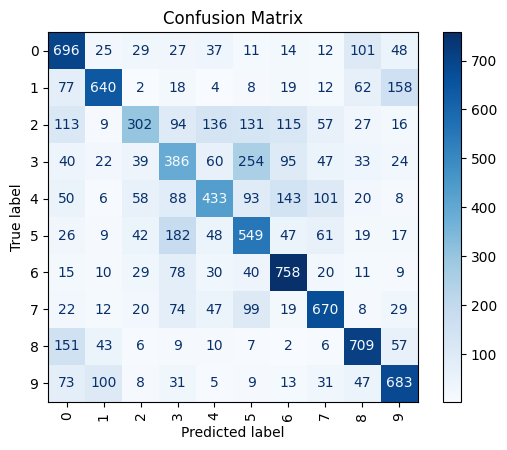

Test Accuracy: 73.54%


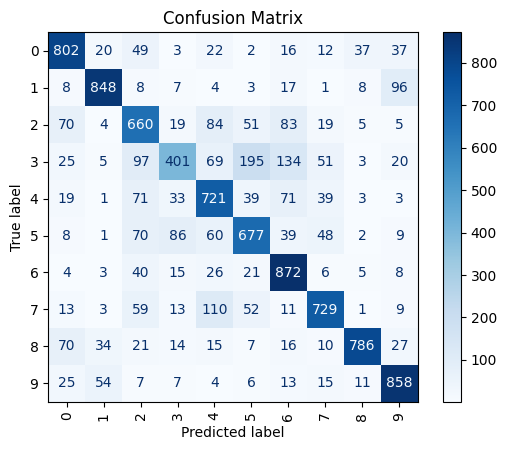

Test Accuracy: 78.52%


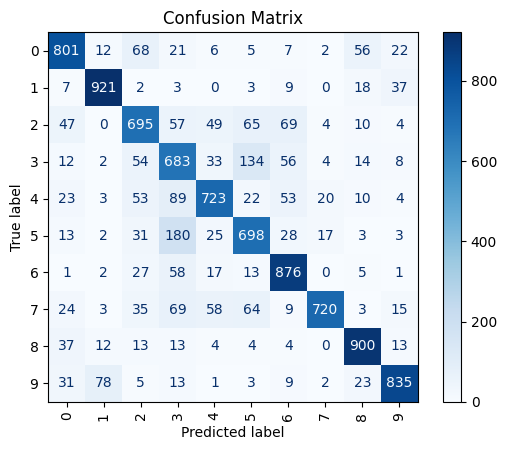

Test Accuracy: 74.93%


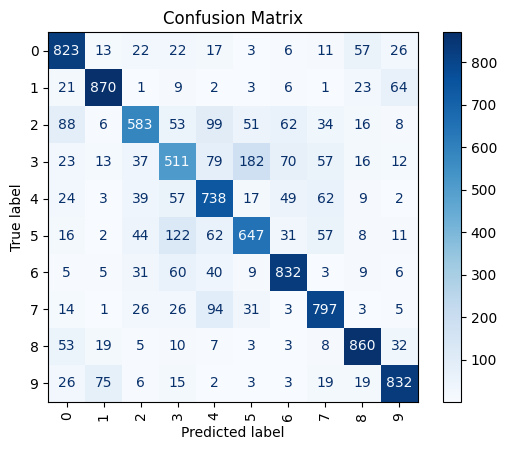

(0.7493,
 array([[823,  13,  22,  22,  17,   3,   6,  11,  57,  26],
        [ 21, 870,   1,   9,   2,   3,   6,   1,  23,  64],
        [ 88,   6, 583,  53,  99,  51,  62,  34,  16,   8],
        [ 23,  13,  37, 511,  79, 182,  70,  57,  16,  12],
        [ 24,   3,  39,  57, 738,  17,  49,  62,   9,   2],
        [ 16,   2,  44, 122,  62, 647,  31,  57,   8,  11],
        [  5,   5,  31,  60,  40,   9, 832,   3,   9,   6],
        [ 14,   1,  26,  26,  94,  31,   3, 797,   3,   5],
        [ 53,  19,   5,  10,   7,   3,   3,   8, 860,  32],
        [ 26,  75,   6,  15,   2,   3,   3,  19,  19, 832]]))

In [37]:
# Evaluate the best model
def evaluate_model(model_path, test_loader, device, model_class):
    # Initialize the model architecture
    model = model_class()
    model.to(device)
    
    # Load the saved state dictionary
    state_dict = torch.load(model_path, weights_only=True)
    model.load_state_dict(state_dict)
    model.eval()
    
    all_preds = []
    all_targets = []

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            
            # Collect all predictions and targets for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2%}")

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, cm

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

evaluate_model("best_BaselineModel.pth", test_loader, device, BaselineModel)
evaluate_model("best_EnhancedModel.pth", test_loader, device, EnhancedModel)
evaluate_model("best_BNModel.pth", test_loader, device, BNModel)
evaluate_model("best_DropoutModel.pth", test_loader, device, DropoutModel)
